In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
import copy

# Load MNIST Data

In [37]:
# Load MNIST data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = (x_train / 255.0)[..., np.newaxis].astype("float32"), (x_test / 255.0)[..., np.newaxis].astype("float32")
x_test, y_test = (x_test).astype("float32"), (y_test).astype("float32")

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Visualize MNIST
- Data sanity check before training

In [38]:
def visualize_mnist(x_train, y_train):
  fig, ax = plt.subplots(2, 5, figsize=(50, 20))
  # Randomly choose an image from each set of images with the same label
  for i in range(10):
    imgs = x_train[y_train == i]
    random_idx = np.random.choice(list(range(len(imgs))))
    random_img = imgs[random_idx, ..., 0]
    ax[i // 5, i % 5].imshow(random_img)
  plt.show()

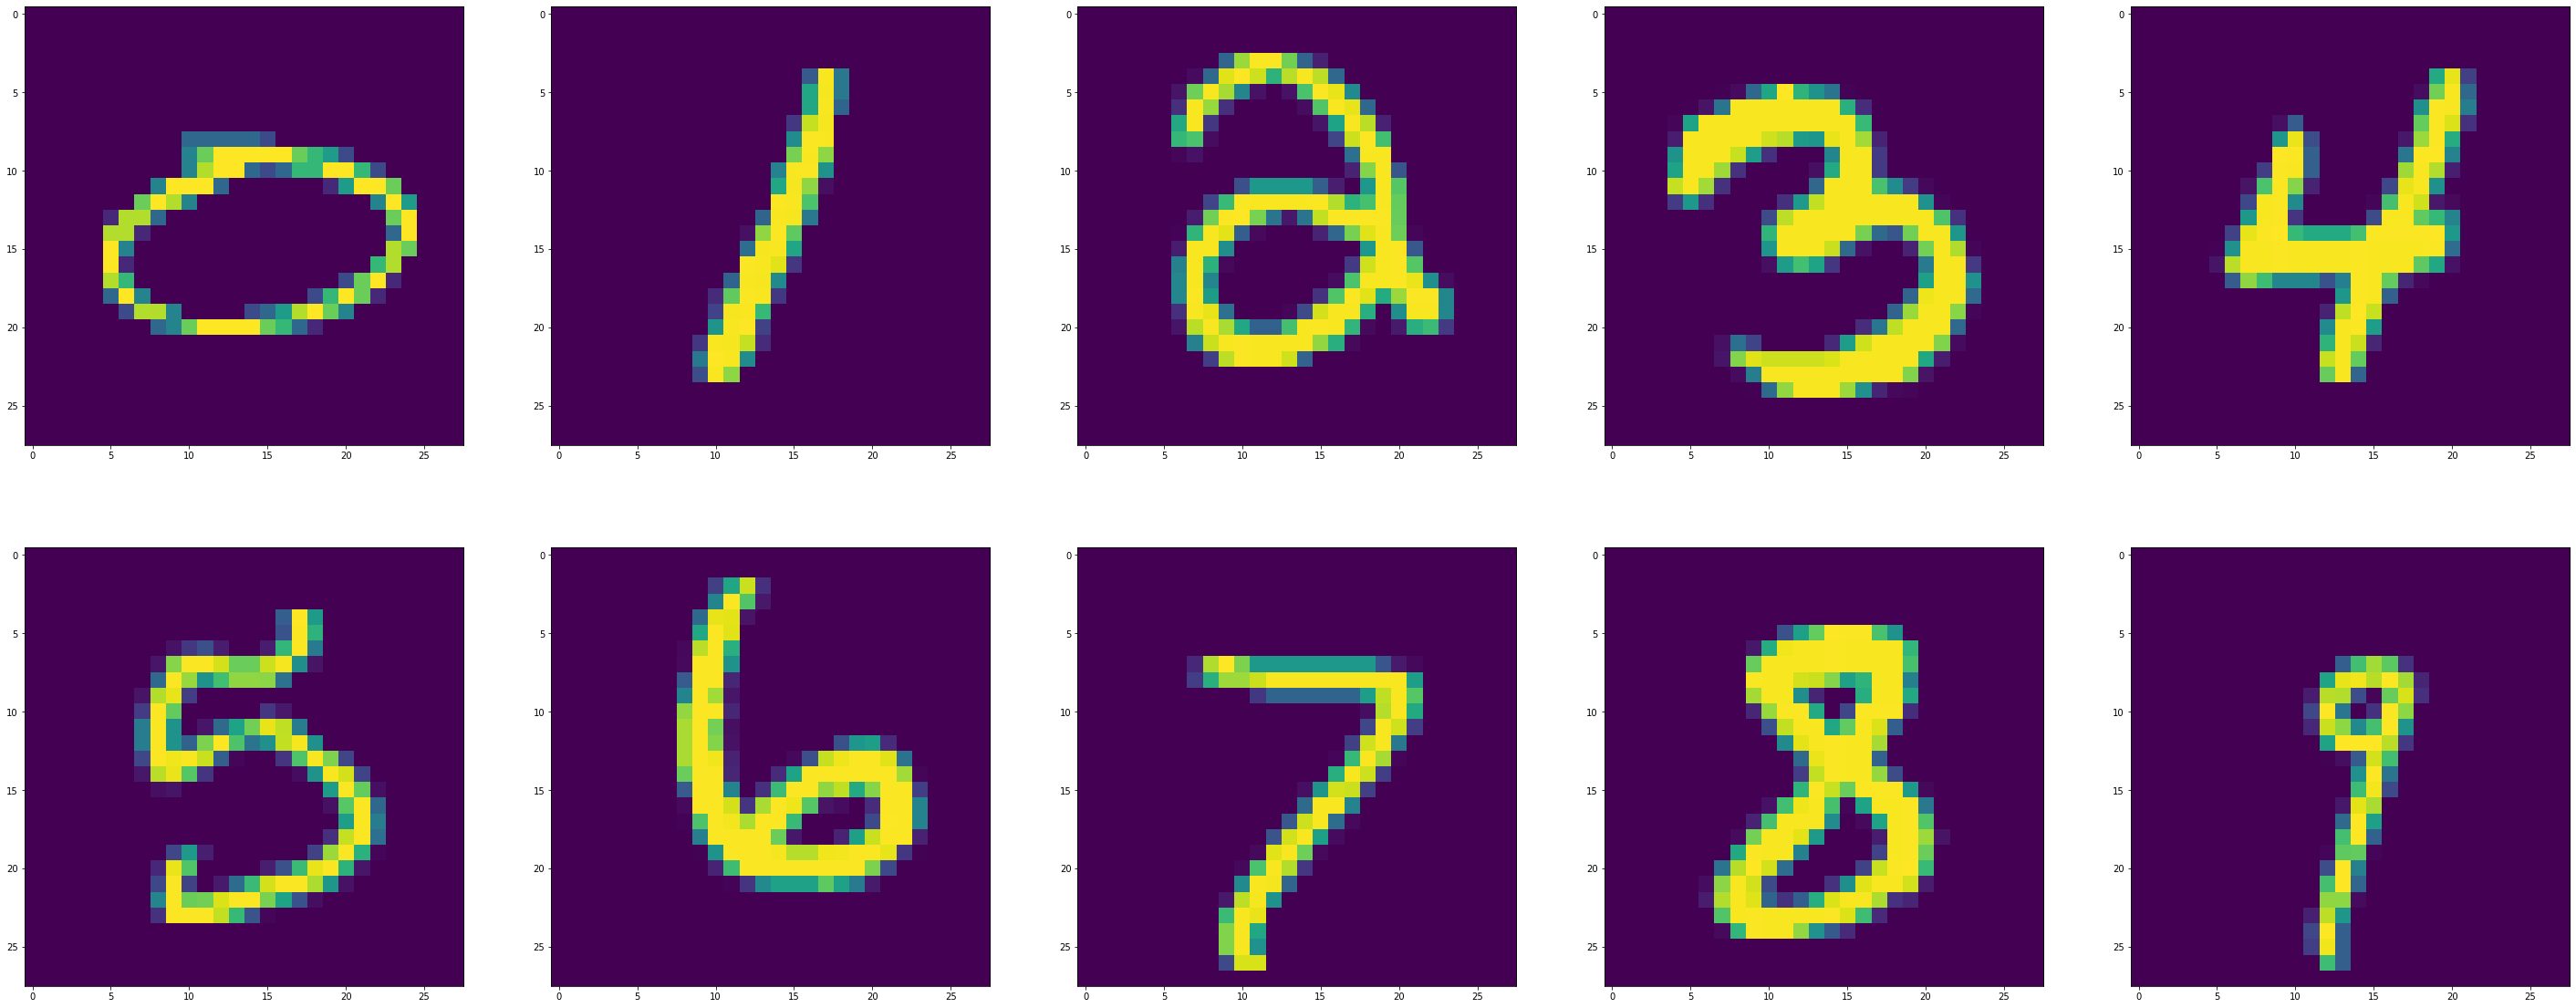

In [39]:
visualize_mnist(x_train, y_train)

# Disclaimer
## As this is my first time to write neural nets in Tensorflow, I copied the most of the training code (from Model to Test Code) from https://www.tensorflow.org/tutorials/quickstart/advanced. I have been a big fan of Pytorch hehe.

# Model

 - We don't use bias here for simplicity

In [40]:
class ModelSoonToBePruned(Model):
  def __init__(self):
    super(ModelSoonToBePruned, self).__init__()
    self.flatten = Flatten()
    # No bias terms for simplicity
    self.fc1 = Dense(1000, activation='relu', use_bias=False)
    self.fc2 = Dense(1000, activation='relu', use_bias=False)
    self.fc3 = Dense(500, activation='relu', use_bias=False)
    self.fc4 = Dense(200, activation='relu', use_bias=False)
    self.fc5 = Dense(10, use_bias=False)

  def call(self, x):
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    logit = self.fc5(x) # no softmax here b.c. we will set from_logits=True
    return logit

# Train

In [41]:
def train_one_step(model, images, labels, optimizer, criterion, train_loss, train_accuracy):
  with tf.GradientTape() as tape:
    pred = model(images)
    loss = criterion(labels, pred)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, pred)
  return model

In [42]:
def test_one_step(model, images, labels, criterion, test_loss, test_accuracy):
  pred = model(images)
  loss = criterion(labels, pred)

  test_loss(loss)
  test_accuracy(labels, pred)

In [43]:
def train(model, train_data, test_data, num_epochs):
  # Metrics
  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_loss.reset_states()

  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  train_accuracy.reset_states()

  test_loss = tf.keras.metrics.Mean(name='test_loss')
  test_loss.reset_states()

  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
  test_accuracy.reset_states()

  # Loss & Optimizer
  criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.Adam()

  for epoch in range(num_epochs):
    for images, labels in train_data:
      model = train_one_step(
                     model, 
                     images, 
                     labels, 
                     optimizer, 
                     criterion,
                     train_loss,
                     train_accuracy
              )
    
    for images, labels in test_data:
      test_one_step(
          model, 
          images, 
          labels, 
          criterion,
          test_loss,
          test_accuracy
      )
    
    print(
        f"Epoch {epoch}\n" \
        f"Train Loss - {train_loss.result():.6f}\n" \
        f"Train Accuracy - {train_accuracy.result()*100:.6f}\n" \
        f"Test Loss - {test_loss.result():.6f}\n" \
        f"Test Accuracy - {test_accuracy.result()*100:.6f}\n"
    )


In [13]:
model = ModelSoonToBePruned()
train(model, train_data, test_data, 5)

Epoch 0
Train Loss - 0.212889
Train Accuracy - 93.643333
Test Loss - 0.134422
Test Accuracy - 95.910004

Epoch 1
Train Loss - 0.159942
Train Accuracy - 95.324997
Test Loss - 0.128105
Test Accuracy - 96.180000

Epoch 2
Train Loss - 0.132362
Train Accuracy - 96.141663
Test Loss - 0.122598
Test Accuracy - 96.633331

Epoch 3
Train Loss - 0.115107
Train Accuracy - 96.667496
Test Loss - 0.111417
Test Accuracy - 96.932503

Epoch 4
Train Loss - 0.102642
Train Accuracy - 97.028000
Test Loss - 0.114275
Test Accuracy - 97.004005



### The training result above seems reasonable (97% accuracy on test dataset). Let's move on to pruning

# Test Code for Pruning

In [44]:
def test(model, test_data):
  # Metrics
  test_loss = tf.keras.metrics.Mean(name='test_loss')
  test_loss.reset_states()

  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
  test_accuracy.reset_states()

  # Dummy loss declaration just to make use of the existing function: test_one_step
  criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  for images, labels in test_data:
    test_one_step(
        model, 
        images, 
        labels, 
        criterion,
        test_loss,
        test_accuracy
    )
  return test_accuracy.result()


# Pruning

- We will prune the weights of the trained neural network based on two methodologies: weight pruning and unit pruning
- Both methodologies will zero out the first smallest k% of each weight matrix for a given model
- A difference is that:
  - Weight pruning will compare indivisual weight when selecting which weights to prune
  - Unit pruning will compare L2 norm of a set of weights that lead to the same output hidden unit when selecting which weights to prune

In [45]:
def weight_pruning(model, percentage):
  model = copy.deepcopy(model)
  # Loop through trainable variables - From: https://stackoverflow.com/questions/62372886/manually-set-the-trainable-variables-weights-in-tensorflow-2
  for i, param in enumerate(model.trainable_variables):
    param = np.array(param)
    if param.shape[1] == 10: # Don't prune the weights that produce the logit
      continue
    # Choose the indices to prune
    indices = np.argsort(np.absolute(param.ravel()))
    num_params_to_prune = int(len(indices)*percentage)
    indices_to_prune = indices[:num_params_to_prune]
    indices_to_prune = np.unravel_index(indices_to_prune, param.shape)

    # Prune the selected indices
    param[indices_to_prune] = 0.0
    # Manually set trainable variables - From: https://stackoverflow.com/questions/62372886/manually-set-the-trainable-variables-weights-in-tensorflow-2
    model.trainable_variables[i].assign(param)
  
    # Final check if the weights have been properly set
    assert np.all(np.array(model.trainable_variables[i]) == param)
  return model

In [46]:
def L2(arr):
  np_arr = np.array(arr)
  return np.sqrt(np.sum(np.square(np_arr)))

def unit_pruning(model, percentage):
  model = copy.deepcopy(model)
  # Loop through trainable variables - From: https://stackoverflow.com/questions/62372886/manually-set-the-trainable-variables-weights-in-tensorflow-2
  for i, param in enumerate(model.trainable_variables):
    param = np.array(param)
    if param.shape[1] == 10: # Don't prune the weights that produce the logit
      continue
    
    # Choose the indices to prune
    num_columns_to_prune = int(param.shape[1]*percentage)
    l2_norm_columns = np.array([L2(param[:, i]) for i in range(param.shape[1])])
    indices_to_prune = np.argsort(l2_norm_columns)[:num_columns_to_prune]
    
    # Prune the selected indices
    param[:, indices_to_prune] = 0.0
    # Manually set trainable variables - From: https://stackoverflow.com/questions/62372886/manually-set-the-trainable-variables-weights-in-tensorflow-2
    model.trainable_variables[i].assign(param)

    # Final check if the weights have been properly set
    assert np.all(np.array(model.trainable_variables[i]) == param)
  return model

In [26]:
pruning_percentages = [0, .25, .50, .60, .70, .80, .90, .95, .97, .99]

In [32]:
models_weight_pruning = []
for p in pruning_percentages:
  models_weight_pruning.append(weight_pruning(model, p))

test_accuracies_weight_pruning = []
for m in models_weight_pruning:
  test_accuracies_weight_pruning.append(float(test(m, test_data)))

models_unit_pruning = []
for p in pruning_percentages:
  models_unit_pruning.append(unit_pruning(model, p))

test_accuracies_unit_pruning = []
for m in models_unit_pruning:
  test_accuracies_unit_pruning.append(float(test(m, test_data)))

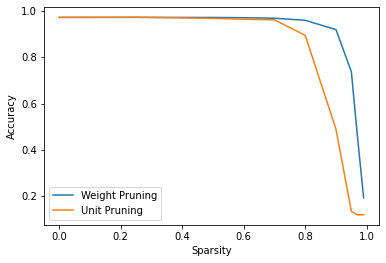

In [47]:
plt.plot(pruning_percentages, test_accuracies_weight_pruning, label="Weight Pruning")
plt.plot(pruning_percentages, test_accuracies_unit_pruning, label="Unit Pruning")
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Result Analysis
- From the figure above, we can observe that deterioration of accruacy occurs faster for unit pruning than weight pruning. We can correlate this result with the role of each hidden unit. A general role of each hidden unit is different from layer to layer, but an important thing to keep in mind is that a hidden unit represents some kind of feature whether it is at a deep layer or not. Doing weight pruning means it sort of "weakens" the role of the hidden unit connected to those weights. For example, let's assume a hidden unit represents how curvy a line is. Then, pruning some of the weights connected to this hidden unit means the next layer will lose "some" of the information about how curvy a line is but won't entirely lose access to the information. On the other hand, pruning all the weights connected to the hidden unit means the next layer will lose the "entirety" of the information on how curvy a line is. With this interpretation in mind, it makes sense that why accuracy for unit pruning deteriorates faster than weight pruning does.
- Another observation that's worthwhile to mention is that for both weight pruning and unit pruning, we can observe that up to 65% sparsity, the accruacy does not decrease - the model maintains its performance. This phenomenon can be related to the fact that we, humans, do not need to see the entire image to infer which number it is (for MNIST dataset). We are actually able to infer correctly without bottom half of each image present. In the same regards, our model is also able to infer correctly without 65% of information present.
- Yet another explanation as to why the model is able to infer correctly up to 65% sparsity is that we removed the first "smallest" k% of the weights. Being small in terms of its magnitude for neural network weights means it does not propagate so much information. In turn, this means only 35% weights are needed to propagate core information and to properly make inferences in this case. Amazing!
- Another perspective I want to add on is that the fact that network is able to maintain its performance is mainly possible due to the nature of this problem - this problem is classification, not regression. If the task was a regression problem, the pruning percentages and metric would have had somewhat closer to linear relationship (although I would need to run experiments to check). In such regards, the reason why the network can maintain a certain level of performance with significant pruning is somewhat alike to the reason why neural network quantization is possible - certain level of error can be tolerated.